In [ ]:
library(tidyverse)
library(readr)
library(dplyr)
library(ggplot2)
library(DBI)
library(ggplot2)
library(ggpubr)
library(tidyr)
library(readr)
library(dplyr)
library(stringr)
library(qvalue)
options(jupyter.plot_mimetypes = "image/png")
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 200)


#### Random shuffling

Rows: 1091532 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): file, sequence, modifications, unmodified sequence, protein id, fl...
dbl (15): scan, charge, spectrum precursor m/z, spectrum neutral mass, pepti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


tailor score,unmodified sequence,xcorr score
<dbl>,<chr>,<dbl>
2.162282,TPGAATASASGAAEDGACGCLPNPGTFEECHRK,7.242484
2.078831,STANGPDKNEPEVEAEQPLCSSQSQCK,7.099700
2.071591,RGSDELFSTCVTNGPFLMSSNSASAANGNDSK,6.875032
2.011143,GSGDPSSSSSSGNPLVYLDVDANGKPLGR,6.362264
1.993317,CSLQAAALLDANDAHQTETSSSQVK,6.859854
1.987193,GGGSAAAAAAAAASGGGVSPDNSLEHSDYR,6.721621


Rows: 1091532 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (8): file, sequence, modifications, unmodified sequence, protein id, fl...
dbl (15): scan, charge, spectrum precursor m/z, spectrum neutral mass, pepti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


tailor score,unmodified sequence,xcorr score
<dbl>,<chr>,<dbl>
1.403644,KLQLGELQQLK,3.790287
1.351077,FGFGFGGGTK,2.339000
1.349702,SGGGGGGLSGGGLSGR,3.022553
1.337739,QQQQQQLQQQR,2.537537
1.329345,PGGGPGGMPGGPGGR,2.383657
1.325964,KQELALELTK,3.085323


tailor score,unmodified sequence,xcorr score,pvalue
<dbl>,<chr>,<dbl>,<dbl>
2.162282,TPGAATASASGAAEDGACGCLPNPGTFEECHRK,7.242484,1
2.078831,STANGPDKNEPEVEAEQPLCSSQSQCK,7.099700,1
2.071591,RGSDELFSTCVTNGPFLMSSNSASAANGNDSK,6.875032,1
2.011143,GSGDPSSSSSSGNPLVYLDVDANGKPLGR,6.362264,1
1.993317,CSLQAAALLDANDAHQTETSSSQVK,6.859854,1
1.987193,GGGSAAAAAAAAASGGGVSPDNSLEHSDYR,6.721621,1


tailor score,unmodified sequence,xcorr score,pvalue,FDR
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
2.162282,TPGAATASASGAAEDGACGCLPNPGTFEECHRK,7.242484,0,0
2.078831,STANGPDKNEPEVEAEQPLCSSQSQCK,7.099700,0,0
2.071591,RGSDELFSTCVTNGPFLMSSNSASAANGNDSK,6.875032,0,0
2.011143,GSGDPSSSSSSGNPLVYLDVDANGKPLGR,6.362264,0,0
1.993317,CSLQAAALLDANDAHQTETSSSQVK,6.859854,0,0
1.987193,GGGSAAAAAAAAASGGGVSPDNSLEHSDYR,6.721621,0,0


[1] 90396

tailor score,unmodified sequence,xcorr score,pvalue,FDR
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
2.162282,TPGAATASASGAAEDGACGCLPNPGTFEECHRK,7.242484,0,0
2.078831,STANGPDKNEPEVEAEQPLCSSQSQCK,7.099700,0,0
2.071591,RGSDELFSTCVTNGPFLMSSNSASAANGNDSK,6.875032,0,0
2.011143,GSGDPSSSSSSGNPLVYLDVDANGKPLGR,6.362264,0,0
1.993317,CSLQAAALLDANDAHQTETSSSQVK,6.859854,0,0
1.987193,GGGSAAAAAAAAASGGGVSPDNSLEHSDYR,6.721621,0,0


[1] 91601

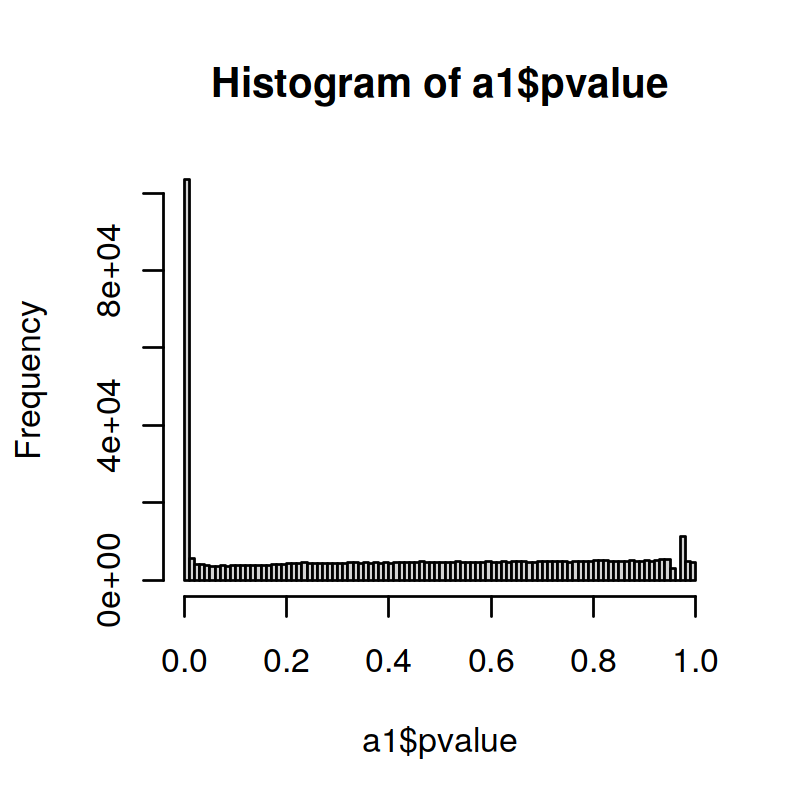

In [8]:
a <- read_tsv("/net/noble/vol1/home/bwen1/project/2023_entrapment_fdr/fdr_evaluation/dda/revision1/PXD001468/tide/UP000005640_9606_1entrapment_pep_result/tide-search.target.txt")
a1 <- a %>% group_by(`unmodified sequence`) %>% arrange(desc(`tailor score`)) %>% select(`tailor score`,`unmodified sequence`,`xcorr score`) %>% filter(row_number()==1) 
head(a1)

b <- read_tsv("/net/noble/vol1/home/bwen1/project/2023_entrapment_fdr/fdr_evaluation/dda/revision1/PXD001468/tide/UP000005640_9606_1entrapment_pep_result/tide-search.decoy.txt")
b1 <- b %>% group_by(`unmodified sequence`) %>% arrange(desc(`tailor score`)) %>% select(`tailor score`,`unmodified sequence`,`xcorr score`) %>% filter(row_number()==1) 
head(b1)

n_total <- nrow(a1)
a1$pvalue <- 1
n_decoy <- nrow(b1)
head(a1)

library(parallel)
# Function to calculate p-value for a given score
calc_pvalue <- function(score, b1_scores, n_decoy) {
  sum(b1_scores >= score) / n_decoy
}
cl <- makeCluster(getOption("cl.cores", 36))
clusterExport(cl, c("calc_pvalue"),envir=environment())
a1$pvalue <- parSapply(cl,a1$`tailor score`,FUN = calc_pvalue,b1_scores=b1$`tailor score`,n_decoy=n_decoy)
stopCluster(cl)

a1$FDR <- p.adjust(a1$pvalue,method = "BH")
head(a1)
hist(a1$pvalue,breaks=100)
sum(a1$FDR<=0.01)
a1 %>% rename(peptide=`unmodified sequence`,q_value=FDR, score=`tailor score`) %>% arrange(q_value,desc(score)) %>% write_tsv("random_shuffle_peptide_fdr_input_bh.tsv")

a1$FDR <- qvalue(a1$pvalue)$qvalues
head(a1)
hist(a1$pvalue,breaks=100)
sum(a1$FDR<=0.01)
a1 %>% rename(peptide=`unmodified sequence`,q_value=FDR, score=`tailor score`) %>% arrange(q_value,desc(score)) %>% write_tsv("random_shuffle_peptide_fdr_input_qvalue.tsv")


#### Foreign species

Rows: 1093476 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): file, sequence, modifications, unmodified sequence, protein id, fl...
dbl (15): scan, charge, spectrum precursor m/z, spectrum neutral mass, pepti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


tailor score,unmodified sequence,xcorr score
<dbl>,<chr>,<dbl>
2.131103,TPGAATASASGAAEDGACGCLPNPGTFEECHRK,7.242484
2.072304,RGSDELFSTCVTNGPFLMSSNSASAANGNDSK,6.875032
2.012033,TPGAATASASGAAEDGACGCLPNPGTFEECHR,6.099502
2.011561,GSGDPSSSSSSGNPLVYLDVDANGKPLGR,6.362264
2.005502,STANGPDKNEPEVEAEQPLCSSQSQCK,7.099700
1.993450,KPADDQDPLDALSGDLDSCPSTTETSQNTAK,6.496910


Rows: 1093474 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (8): file, sequence, modifications, unmodified sequence, protein id, fl...
dbl (15): scan, charge, spectrum precursor m/z, spectrum neutral mass, pepti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


tailor score,unmodified sequence,xcorr score
<dbl>,<chr>,<dbl>
1.424450,KGDLLLGTVATSGGK,3.313415
1.410287,SGSGGGYGGGSGGGGYSGGSGGR,2.681178
1.395993,QQQQQLQQQQR,2.839456
1.350805,LLPKLLLLK,1.977403
1.339958,KAEELSELTGLDDDVK,2.689084
1.318518,NGEGGDDDQQDSTWLTLNDN,1.941036


tailor score,unmodified sequence,xcorr score,pvalue
<dbl>,<chr>,<dbl>,<dbl>
2.131103,TPGAATASASGAAEDGACGCLPNPGTFEECHRK,7.242484,1
2.072304,RGSDELFSTCVTNGPFLMSSNSASAANGNDSK,6.875032,1
2.012033,TPGAATASASGAAEDGACGCLPNPGTFEECHR,6.099502,1
2.011561,GSGDPSSSSSSGNPLVYLDVDANGKPLGR,6.362264,1
2.005502,STANGPDKNEPEVEAEQPLCSSQSQCK,7.099700,1
1.993450,KPADDQDPLDALSGDLDSCPSTTETSQNTAK,6.496910,1


tailor score,unmodified sequence,xcorr score,pvalue,FDR
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
2.131103,TPGAATASASGAAEDGACGCLPNPGTFEECHRK,7.242484,0,0
2.072304,RGSDELFSTCVTNGPFLMSSNSASAANGNDSK,6.875032,0,0
2.012033,TPGAATASASGAAEDGACGCLPNPGTFEECHR,6.099502,0,0
2.011561,GSGDPSSSSSSGNPLVYLDVDANGKPLGR,6.362264,0,0
2.005502,STANGPDKNEPEVEAEQPLCSSQSQCK,7.099700,0,0
1.993450,KPADDQDPLDALSGDLDSCPSTTETSQNTAK,6.496910,0,0


[1] 92214

tailor score,unmodified sequence,xcorr score,pvalue,FDR
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
2.131103,TPGAATASASGAAEDGACGCLPNPGTFEECHRK,7.242484,0,0
2.072304,RGSDELFSTCVTNGPFLMSSNSASAANGNDSK,6.875032,0,0
2.012033,TPGAATASASGAAEDGACGCLPNPGTFEECHR,6.099502,0,0
2.011561,GSGDPSSSSSSGNPLVYLDVDANGKPLGR,6.362264,0,0
2.005502,STANGPDKNEPEVEAEQPLCSSQSQCK,7.099700,0,0
1.993450,KPADDQDPLDALSGDLDSCPSTTETSQNTAK,6.496910,0,0


[1] 93026

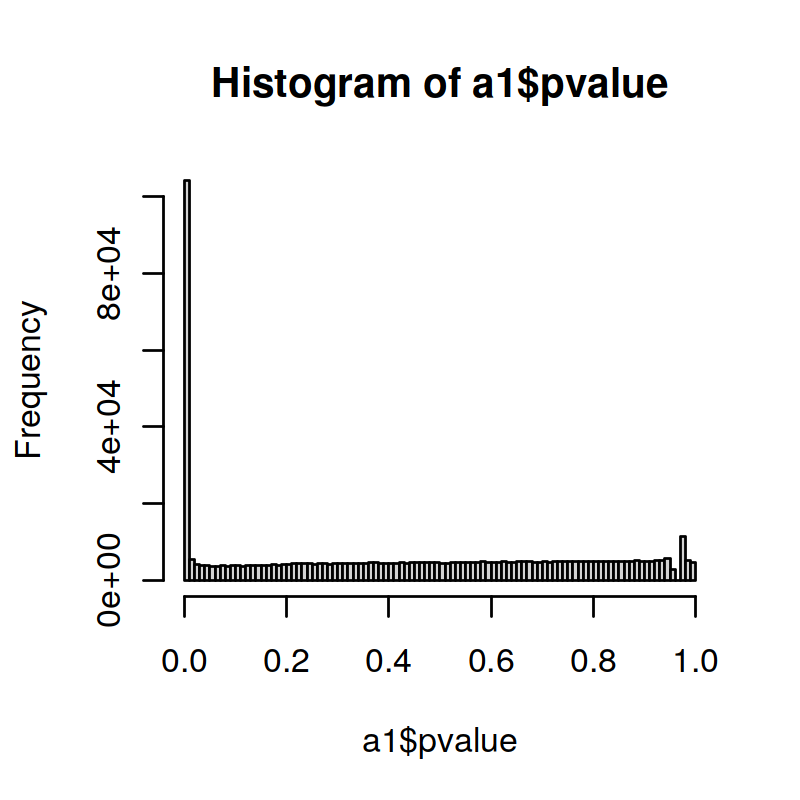

In [9]:
a <- read_tsv("/net/noble/vol1/home/bwen1/project/2023_entrapment_fdr/fdr_evaluation/dda/revision1/PXD001468/tide_Arabidopsis_thaliana/UP000005640_9606_1entrapment_pep_result/tide-search.target.txt")
a1 <- a %>% group_by(`unmodified sequence`) %>% arrange(desc(`tailor score`)) %>% select(`tailor score`,`unmodified sequence`,`xcorr score`) %>% filter(row_number()==1) 
head(a1)

b <- read_tsv("/net/noble/vol1/home/bwen1/project/2023_entrapment_fdr/fdr_evaluation/dda/revision1/PXD001468/tide_Arabidopsis_thaliana/UP000005640_9606_1entrapment_pep_result/tide-search.decoy.txt")
b1 <- b %>% group_by(`unmodified sequence`) %>% arrange(desc(`tailor score`)) %>% select(`tailor score`,`unmodified sequence`,`xcorr score`) %>% filter(row_number()==1) 
head(b1)

n_total <- nrow(a1)
a1$pvalue <- 1
n_decoy <- nrow(b1)
head(a1)

library(parallel)
# Function to calculate p-value for a given score
calc_pvalue <- function(score, b1_scores, n_decoy) {
  sum(b1_scores >= score) / n_decoy
}
cl <- makeCluster(getOption("cl.cores", 36))
clusterExport(cl, c("calc_pvalue"),envir=environment())
a1$pvalue <- parSapply(cl,a1$`tailor score`,FUN = calc_pvalue,b1_scores=b1$`tailor score`,n_decoy=n_decoy)
stopCluster(cl)

a1$FDR <- p.adjust(a1$pvalue,method = "BH")
head(a1)
hist(a1$pvalue,breaks=100)
sum(a1$FDR<=0.01)
a1 %>% rename(peptide=`unmodified sequence`,q_value=FDR, score=`tailor score`) %>% arrange(q_value,desc(score)) %>% write_tsv("foreign_species_peptide_fdr_input_bh.tsv")

a1$FDR <- qvalue(a1$pvalue)$qvalues
head(a1)
hist(a1$pvalue,breaks=100)
sum(a1$FDR<=0.01)
a1 %>% rename(peptide=`unmodified sequence`,q_value=FDR, score=`tailor score`) %>% arrange(q_value,desc(score)) %>% write_tsv("foreign_species_peptide_fdr_input_qvalue.tsv")


png 
  2

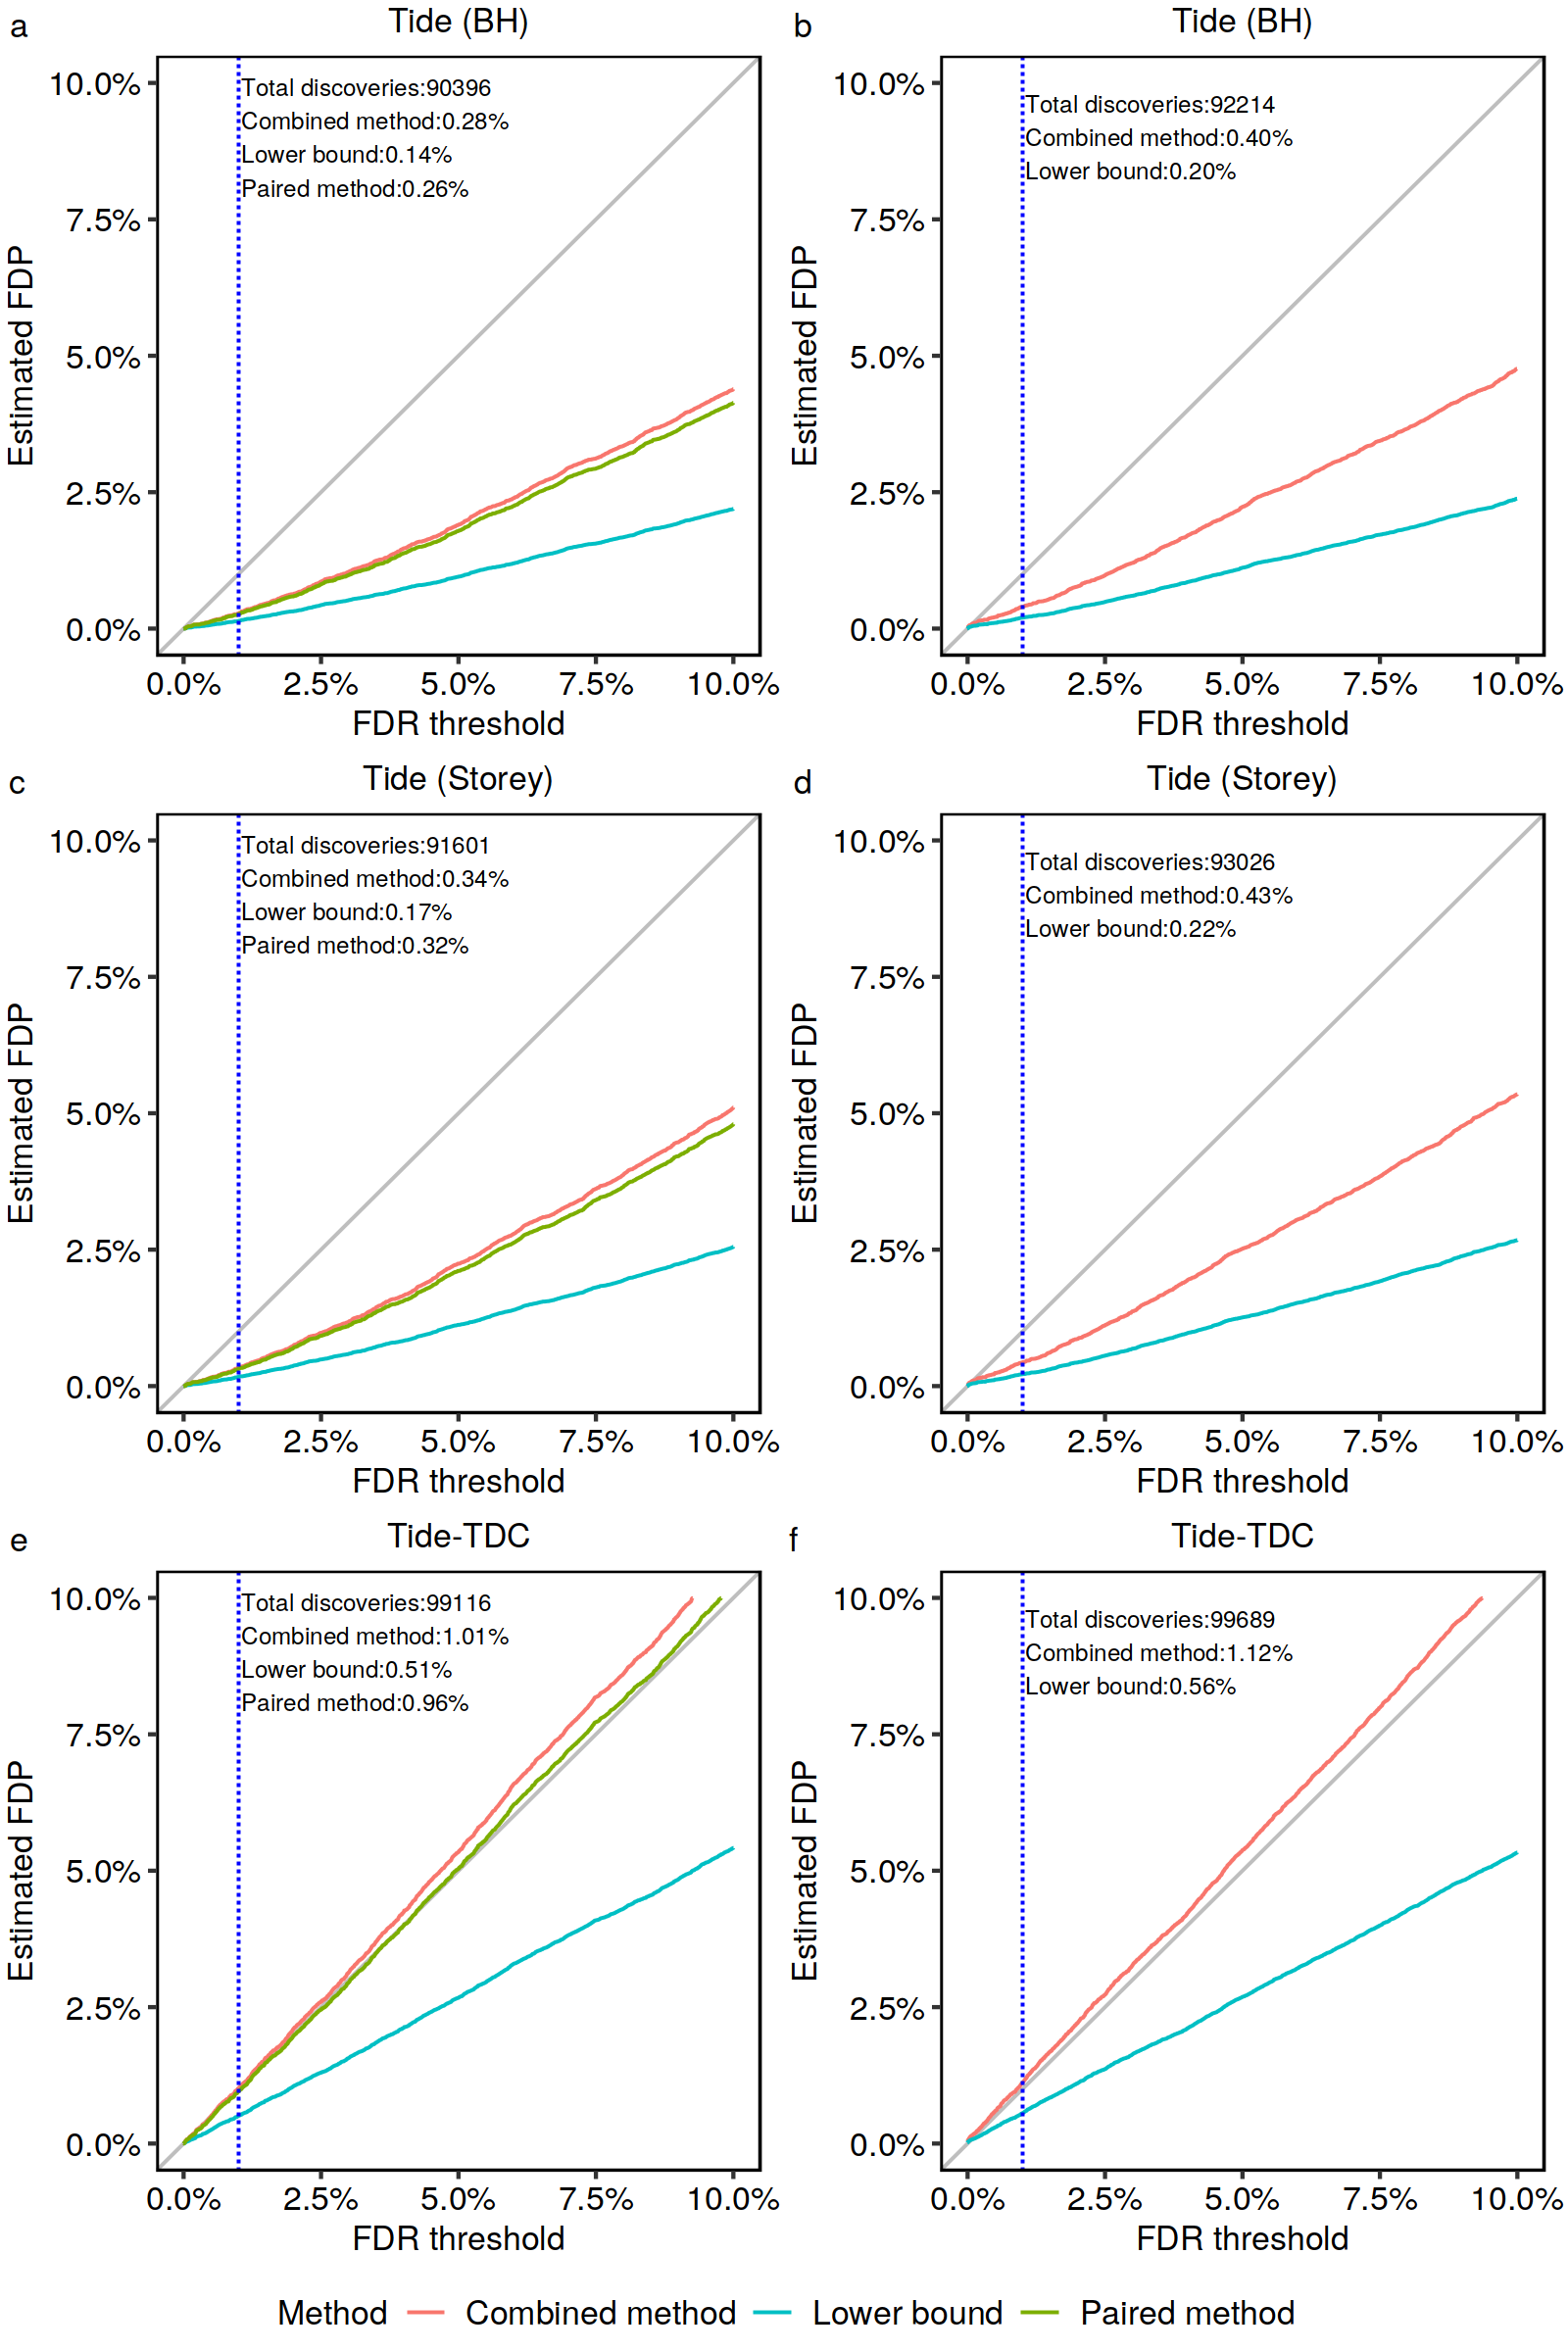

In [11]:
source("/data/scratch/bwen1/project/2023_entrapment_fdr/bin/run_fdp_calc.R")
# color_mapping <- c("Paired entrapment" = "blue", "Sample entrapment" = "red", "Lower bound" = "green", "Combined entrapment" = "purple")
color_mapping <- c("Paired method" = "#7CAE00", "Sample method" = "#C77CFF", "Lower bound" = "#00BFC4", "Combined method" = "#F8766D")


### Tide peptide level
report_file <- "./random_shuffle_peptide_fdr_input_bh.tsv"
pep_file <- "/data/scratch/bwen1/project/2023_entrapment_fdr/database/UP000005640_9606_entrapment_pep.txt"
pro_fdp_file1 <- run_fdp_analysis(report_file,level = "peptide",prefix = "random-tide_BH-peptide",pep_file = pep_file,k_fold=1)
gg1 <- plot_fdp_fdr_v2(pro_fdp_file1,fdr_max = 0.1,fig_title="Tide (BH)",add_numbers = TRUE, color_mapping=color_mapping,legend_position=c(0.5,0.5),fdr_decimal_place = 2)

report_file <- "./random_shuffle_peptide_fdr_input_qvalue.tsv"
pep_file <- "/data/scratch/bwen1/project/2023_entrapment_fdr/database/UP000005640_9606_entrapment_pep.txt"
pro_fdp_file1 <- run_fdp_analysis(report_file,level = "peptide",prefix = "random-tide_qvalue-peptide",pep_file = pep_file,k_fold=1)
gg2 <- plot_fdp_fdr_v2(pro_fdp_file1,fdr_max = 0.1,fig_title="Tide (Storey)",add_numbers = TRUE, color_mapping=color_mapping,legend_position=c(0.5,0.5),fdr_decimal_place = 2)


report_file <- "./foreign_species_peptide_fdr_input_bh.tsv"
pep_file <- "/data/scratch/bwen1/project/2023_entrapment_fdr/fdr_evaluation/diann/PXD042704_Human_Astral/peptide_level_primates/human_20k_distant/UP000005640_9606_I2L_Arabidopsis_thaliana_entrapment_peptide_level_pep.txt"
pro_fdp_file1 <- run_fdp_analysis(report_file,level = "peptide",prefix = "foreign-tide_BH-peptide",pep_file = pep_file,r=1)
gg3 <- plot_fdp_fdr_v2(pro_fdp_file1,fdr_max = 0.1,fig_title="Tide (BH)",add_numbers = TRUE, color_mapping=color_mapping,legend_position=c(0.5,0.5),fdr_decimal_place = 2)


report_file <- "./foreign_species_peptide_fdr_input_qvalue.tsv"
pep_file <- "/data/scratch/bwen1/project/2023_entrapment_fdr/fdr_evaluation/diann/PXD042704_Human_Astral/peptide_level_primates/human_20k_distant/UP000005640_9606_I2L_Arabidopsis_thaliana_entrapment_peptide_level_pep.txt"
pro_fdp_file1 <- run_fdp_analysis(report_file,level = "peptide",prefix = "foreign-tide_qvalue-peptide",pep_file = pep_file,r=1)
gg4 <- plot_fdp_fdr_v2(pro_fdp_file1,fdr_max = 0.1,fig_title="Tide (Storey)",add_numbers = TRUE, color_mapping=color_mapping,legend_position=c(0.5,0.5),fdr_decimal_place = 2)

a <- read_tsv("./../tide_repeat_runs/Bo_share_entrapment_results/entrapment_results_HEK293_tailor.csv")
a$Peptide <- str_replace_all(a$Peptide,"^-.","") %>% str_replace_all(".-$","")
a$SVM_score <- a$TailorScore
a %>% write_tsv("./../tide_repeat_runs/Bo_share_entrapment_results/entrapment_results_HEK293_tailor_format.tsv")
pep_file <- "/data/scratch/bwen1/project/2023_entrapment_fdr/database/UP000005640_9606_entrapment_pep.txt"
pro_fdp_file1 <- run_percolator_reset_fdp_analysis("./../tide_repeat_runs/Bo_share_entrapment_results/entrapment_results_HEK293_tailor_format.tsv",level = "peptide",prefix = "random-tide_tailorscore-peptide",pep_file = pep_file,k_fold=1)
gg5 <- plot_fdp_fdr_v2(pro_fdp_file1,fdr_max = 0.1,fig_title="Tide-TDC",add_numbers = TRUE, color_mapping=color_mapping,legend_position=c(0.5,0.5),fdr_decimal_place = 2)

a <- read_tsv("./../tide_repeat_runs/Bo_share_entrapment_results/entrapment_results_HEK293_arabidopsis_tailor.csv")
a$Peptide <- str_replace_all(a$Peptide,"^-.","") %>% str_replace_all(".-$","")
a$SVM_score <- a$TailorScore
a %>% write_tsv("./../tide_repeat_runs/Bo_share_entrapment_results/entrapment_results_HEK293_arabidopsis_tailor_format.tsv")
pep_file <- "/data/scratch/bwen1/project/2023_entrapment_fdr/fdr_evaluation/diann/PXD042704_Human_Astral/peptide_level_primates/human_20k_distant/UP000005640_9606_I2L_Arabidopsis_thaliana_entrapment_peptide_level_pep.txt"
pro_fdp_file1 <- run_percolator_reset_fdp_analysis("./../tide_repeat_runs/Bo_share_entrapment_results/entrapment_results_HEK293_arabidopsis_tailor_format.tsv",level = "peptide",prefix = "foreign-tide_tailorscore-peptide",pep_file = pep_file,r=1)
gg6 <- plot_fdp_fdr_v2(pro_fdp_file1,fdr_max = 0.1,fig_title="Tide-TDC",add_numbers = TRUE, color_mapping=color_mapping,legend_position=c(0.5,0.5),fdr_decimal_place = 2)


options(jupyter.plot_mimetypes = "image/png")
#options(repr.plot.width = 4*2, repr.plot.height = 4*2, repr.plot.res = 200)
options(repr.plot.width = 4*2, repr.plot.height = 4*3, repr.plot.res = 200)
#library(cowplot)
#legend <- as_ggplot(get_legend(gg1))+theme(legend.position = c(0.5, 0.5))
gg <- ggarrange(gg1+theme(plot.title = element_text(size = 12, hjust = 0.5),plot.margin = unit(c(0.1,0.3,0.2,0.1), "cm")),
                gg3+theme(plot.title = element_text(size = 12, hjust = 0.5),plot.margin = unit(c(0.1,0.3,0.2,0.1), "cm")),
                gg2+theme(plot.title = element_text(size = 12, hjust = 0.5),plot.margin = unit(c(0.1,0.3,0.2,0.1), "cm")),
                gg4+theme(plot.title = element_text(size = 12, hjust = 0.5),plot.margin = unit(c(0.1,0.3,0.2,0.1), "cm")),
                gg5+theme(plot.title = element_text(size = 12, hjust = 0.5),plot.margin = unit(c(0.1,0.3,0.2,0.1), "cm")),
                gg6+theme(plot.title = element_text(size = 12, hjust = 0.5),plot.margin = unit(c(0.1,0.3,0.2,0.1), "cm")),
                legend = "bottom", common.legend=TRUE, ncol = 2, nrow = 3, align = "hv",
                labels = c("a", "b", "c", "d","e","f"), font.label = list(size = 12, color = "black", face = "plain"))
print(gg)

pdf("FigureS-tide-BH-HEK.pdf",width = 3.5*2,height = 3.5*3) 
print(gg)
dev.off()